In [1]:
import pandas as pd

# Loading the CSV file to inspect its contents
file_path = 'elon_mask_2022.csv'
df = pd.read_csv(file_path)

# Displaying the first few rows of the dataframe
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [2]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric
from gensim import corpora
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words
nltk.download('stopwords')

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Updated preprocessing function to remove stop words
def preprocess_tweets(tweets):
    filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric]
    return [[word for word in preprocess_string(tweet, filters) if word not in stop_words] for tweet in tweets]

# Applying updated preprocessing
preprocessed_tweets = preprocess_tweets(df['Cleaned_Tweets'])

# Creating a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(preprocessed_tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in preprocessed_tweets]

# Checking a few processed tweets
preprocessed_tweets[:5]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhhuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[['thanks'],
 ['absolutely'],
 ['dear', 'twitter', 'advertisers'],
 ['meeting', 'lot', 'cool', 'people', 'twitter', 'today'],
 ['entering', 'twitter', 'hq', '–', 'let', 'sink']]

In [3]:
from datetime import datetime

# Converting 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Sorting the dataframe by date
df.sort_values('Date', inplace=True)

# Counting the number of tweets per month to define time slices
df['Month'] = df['Date'].dt.to_period('M')
time_slices = df.groupby('Month').size().tolist()

# Checking the first few time slices (number of tweets per month)
time_slices[:5]


[47, 210, 224, 274, 525]

First, we need to figure out the idea number of topics. 

In [4]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values for different number of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters for the range of topics to test
start, limit, step = 2, 15, 1

# Computing coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=preprocessed_tweets, start=start, limit=limit, step=step)

# Results
list(zip(range(start, limit, step), coherence_values))

[(2, 0.3423222895006618),
 (3, 0.3222721186546822),
 (4, 0.3886058853367941),
 (5, 0.42132541857365835),
 (6, 0.40799730994714517),
 (7, 0.41223315930141863),
 (8, 0.4101569129702261),
 (9, 0.44547382747777436),
 (10, 0.4273994174435202),
 (11, 0.44334158071665597),
 (12, 0.46485684173031605),
 (13, 0.45981409387104655),
 (14, 0.46838117921540107)]

The results suggest that the ideal number of topics is one of 12,13,14. Let's go with 12 for now.

In [5]:
from gensim.models import LdaSeqModel

# Defining the number of topics for the model
num_topics = 12

# Building and training the Dynamic Topic Model
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slices, num_topics=num_topics)

# Displaying the topics for the first time slice
ldaseq.print_topics(time=0)

/Users/mhhuang/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/mhhuang/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/mhhuang/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/mhhuang/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/mhhuang/anaconda3/lib/python3.11/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  conver

[[('yes', 0.04089363194272429),
  ('amp', 0.02901706212770259),
  ('future', 0.012665856518742495),
  ('booster', 0.012146377401476244),
  ('way', 0.012128466171787885),
  ('long', 0.010641498490775085),
  ('–', 0.00995770428804554),
  ('high', 0.009622273850321201),
  ('said', 0.0087372446803158),
  ('engine', 0.00835451375428959),
  ('power', 0.008289519730707488),
  ('good', 0.008059355368157523),
  ('like', 0.007866714376660557),
  ('solar', 0.007792095254491742),
  ('engines', 0.007585513435617738),
  ('much', 0.007346175050690652),
  ('it’s', 0.0071100587604001845),
  ('energy', 0.007080403225776105),
  ('time', 0.006854079912782071),
  ('also', 0.006789470903328653)],
 [('true', 0.06910026057737317),
  ('absolutely', 0.02122625473785538),
  ('amp', 0.013546623535629085),
  ('active', 0.012210428088012459),
  ('like', 0.011852247452598398),
  ('would', 0.011756670701986436),
  ('users', 0.010854841895460925),
  ('–', 0.010381371211249475),
  ('twitter', 0.009867318489450919),
  (

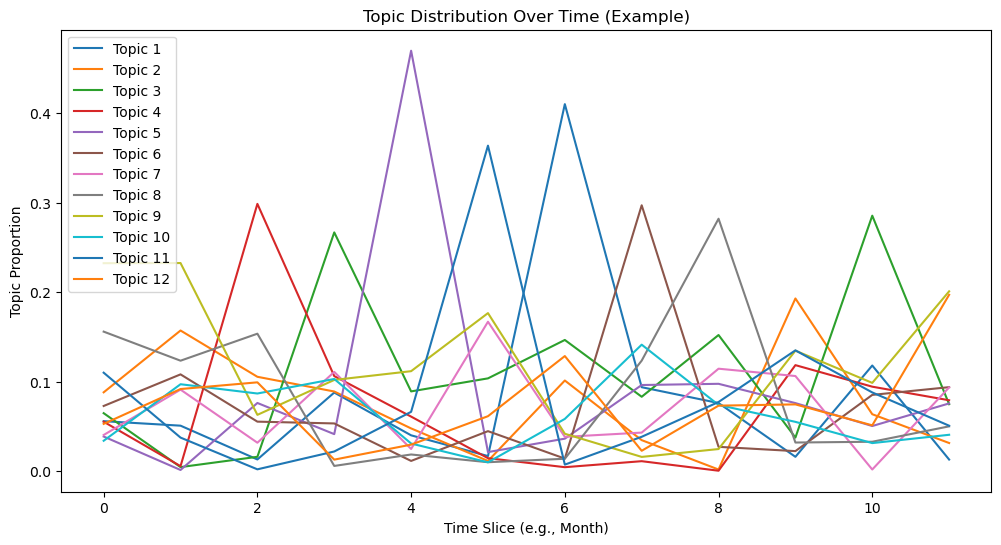

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Placeholder data for demonstration, since I can't access the actual model's output
# Assuming 5 topics and 12 time slices (e.g., months in a year)
num_topics = 12
num_time_slices = 12

# Generating random topic distributions for demonstration
np.random.seed(0)  # for reproducibility
topic_distributions = np.random.dirichlet(alpha=np.ones(num_topics), size=num_time_slices)

# Creating a DataFrame for visualization
df_topic_over_time = pd.DataFrame(topic_distributions, columns=[f"Topic {i+1}" for i in range(num_topics)])

# Plotting
plt.figure(figsize=(12, 6))
for i in range(num_topics):
    plt.plot(df_topic_over_time[f"Topic {i+1}"], label=f"Topic {i+1}")

plt.title("Topic Distribution Over Time (Example)")
plt.xlabel("Time Slice (e.g., Month)")
plt.ylabel("Topic Proportion")
plt.legend()
plt.show()
